# Convolutional Networks
So far we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.

First you will implement several layer types that are used in convolutional networks. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.

In [1]:
# As usual, a bit of setup

import numpy as np
import matplotlib.pyplot as plt
from cnn import *
from data_utils import get_CIFAR10_data
from gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from layers import *
from fast_layers import *
from solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape

X_val:  (1000, 3, 32, 32)
X_train:  (49000, 3, 32, 32)
X_test:  (1000, 3, 32, 32)
y_val:  (1000,)
y_train:  (49000,)
y_test:  (1000,)


# Convolution: Naive forward pass
The core of a convolutional network is the convolution operation. In the file `layers.py`, implement the forward pass for the convolution layer in the function `conv_forward_naive`. 

You don't have to worry too much about efficiency at this point; just write the code in whatever way you find most clear.

You can test your implementation by running the following:

In [3]:
x_shape = (2, 3, 4, 4)
theta_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
theta = np.linspace(-0.2, 0.3, num=np.prod(theta_shape)).reshape(theta_shape)
theta0 = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, theta, theta0, conv_param)
correct_out = np.array([[[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]]])

# Compare your output to ours; difference should be around 1e-8
print 'Testing conv_forward_naive'
print 'difference: ', rel_error(out, correct_out)

Testing conv_forward_naive
difference:  2.21214764175e-08


# Aside: Image processing via convolutions

As fun way to both check your implementation and gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations (grayscale conversion and edge detection). The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check.

/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # This is added back by InteractiveShellApp.init_path()


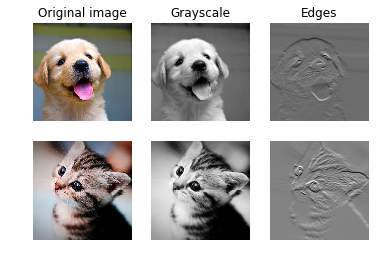

In [4]:
from scipy.misc import imread, imresize

kitten, puppy = imread('kitten.jpg'), imread('puppy.jpg')
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d/2:-d/2, :]

img_size = 200   # Make this smaller if it runs too slow
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = imresize(puppy, (img_size, img_size)).transpose((2, 0, 1))
x[1, :, :, :] = imresize(kitten_cropped, (img_size, img_size)).transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
theta = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
theta[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
theta[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
theta[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
theta[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
theta0 = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = conv_forward_naive(x, theta, theta0, {'stride': 1, 'pad': 1})

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_noax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_noax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_noax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_noax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_noax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_noax(out[1, 1])
plt.show()

# Convolution: Naive backward pass
Implement the backward pass for the convolution operation in the function `conv_backward_naive` in the file `layers.py`. Again, you don't need to worry too much about computational efficiency.

When you are done, run the following to check your backward pass with a numeric gradient check.

In [5]:
x = np.random.randn(4, 3, 5, 5)
theta = np.random.randn(2, 3, 3, 3)
theta0 = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, theta, theta0, conv_param)[0], x, dout)
dtheta_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, theta, theta0, conv_param)[0], theta, dout)
dtheta0_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, theta, theta0, conv_param)[0], theta0, dout)

out, cache = conv_forward_naive(x, theta, theta0, conv_param)
dx, dtheta, dtheta0 = conv_backward_naive(dout, cache)

# Your errors should be around 1e-9'
print 'Testing conv_backward_naive function'
print 'dx error: ', rel_error(dx, dx_num)
print 'dtheta error: ', rel_error(dtheta, dtheta_num)
print 'dtheta0 error: ', rel_error(dtheta0, dtheta0_num)

Testing conv_backward_naive function
dx error:  3.72903401513e-09
dtheta error:  9.65400201938e-10
dtheta0 error:  7.20553220064e-12


# Max pooling: Naive forward
Implement the forward pass for the max-pooling operation in the function `max_pool_forward_naive` in the file `layers.py`. Again, don't worry too much about computational efficiency.

Check your implementation by running the following:

In [6]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be around 1e-8.
print 'Testing max_pool_forward_naive function:'
print 'difference: ', rel_error(out, correct_out)

Testing max_pool_forward_naive function:
difference:  4.16666651573e-08


# Max pooling: Naive backward
Implement the backward pass for the max-pooling operation in the function `max_pool_backward_naive` in the file `layers.py`. You don't need to worry about computational efficiency.

Check your implementation with numeric gradient checking by running the following:

In [7]:
x = np.random.randn(3, 2, 8, 8)
x[0,0,0:2,0:2]
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

# Your error should be around 1e-12
print 'Testing max_pool_backward_naive function:'
print 'dx error: ', rel_error(dx, dx_num)

Testing max_pool_backward_naive function:
dx error:  3.27563684981e-12


# Fast layers
Making convolution and pooling layers fast can be challenging. To spare you the pain, we've provided fast implementations of the forward and backward passes for convolution and pooling layers in the file `fast_layers.py`.

The fast convolution implementation depends on a Cython extension; to compile it you need to run the following from the `pa5-code` directory:

```bash
python setup.py build_ext --inplace
```

The API for the fast versions of the convolution and pooling layers is exactly the same as the naive versions that you implemented above: the forward pass receives data, weights, and parameters and produces outputs and a cache object; the backward pass recieves upstream derivatives and the cache object and produces gradients with respect to the data and weights.

**NOTE:** The fast implementation for pooling will only perform optimally if the pooling regions are non-overlapping and tile the input. If these conditions are not met then the fast pooling implementation will not be much faster than the naive implementation.

You can compare the performance of the naive and fast versions of these layers by running the following:

In [8]:
from fast_layers import conv_forward_fast, conv_backward_fast
from time import time

x = np.random.randn(100, 3, 31, 31)
theta = np.random.randn(25, 3, 3, 3)
theta0 = np.random.randn(25,)
dout = np.random.randn(100, 25, 16, 16)
conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_naive, cache_naive = conv_forward_naive(x, theta, theta0, conv_param)
t1 = time()
out_fast, cache_fast = conv_forward_fast(x, theta, theta0, conv_param)
t2 = time()

print 'Testing conv_forward_fast:'
print 'Naive: %fs' % (t1 - t0)
print 'Fast: %fs' % (t2 - t1)
print 'Speedup: %fx' % ((t1 - t0) / (t2 - t1))
print 'Difference: ', rel_error(out_naive, out_fast)

t0 = time()
dx_naive, dtheta_naive, dtheta0_naive = conv_backward_naive(dout, cache_naive)
t1 = time()
dx_fast, dtheta_fast, dtheta0_fast = conv_backward_fast(dout, cache_fast)
t2 = time()

print '\nTesting conv_backward_fast:'
print 'Naive: %fs' % (t1 - t0)
print 'Fast: %fs' % (t2 - t1)
print 'Speedup: %fx' % ((t1 - t0) / (t2 - t1))
print 'dx difference: ', rel_error(dx_naive, dx_fast)
print 'dw difference: ', rel_error(dtheta_naive, dtheta_fast)
print 'db difference: ', rel_error(dtheta0_naive, dtheta0_fast)

Testing conv_forward_fast:
Naive: 4.908073s
Fast: 0.020846s
Speedup: 235.442900x
Difference:  1.19801968075e-11

Testing conv_backward_fast:
Naive: 8.918954s
Fast: 0.009444s
Speedup: 944.404458x
dx difference:  1.02958906606e-11
dw difference:  5.31637498595e-13
db difference:  4.49004625129e-15


In [9]:
from fast_layers import max_pool_forward_fast, max_pool_backward_fast

x = np.random.randn(100, 3, 32, 32)
dout = np.random.randn(100, 3, 16, 16)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time()
out_naive, cache_naive = max_pool_forward_naive(x, pool_param)
t1 = time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t2 = time()

print 'Testing pool_forward_fast:'
print 'Naive: %fs' % (t1 - t0)
print 'fast: %fs' % (t2 - t1)
print 'speedup: %fx' % ((t1 - t0) / (t2 - t1))
print 'difference: ', rel_error(out_naive, out_fast)

t0 = time()
dx_naive = max_pool_backward_naive(dout, cache_naive)
t1 = time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t2 = time()

print '\nTesting pool_backward_fast:'
print 'Naive: %fs' % (t1 - t0)
print 'speedup: %fx' % ((t1 - t0) / (t2 - t1))
print 'dx difference: ', rel_error(dx_naive, dx_fast)

Testing pool_forward_fast:
Naive: 0.199903s
fast: 0.002249s
speedup: 88.885190x
difference:  0.0

Testing pool_backward_fast:
Naive: 0.355105s
speedup: 31.881713x
dx difference:  0.0


# Convolutional "sandwich" layers
Previously we introduced the concept of "sandwich" layers that combine multiple operations into commonly used patterns. In the file `layer_utils.py` you will find sandwich layers that implement a few commonly used patterns for convolutional networks.

In [10]:
from layer_utils import conv_relu_pool_forward, conv_relu_pool_backward

x = np.random.randn(2, 3, 16, 16)
theta = np.random.randn(3, 3, 3, 3)
theta0 = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_relu_pool_forward(x, theta, theta0, conv_param, pool_param)
dx, dtheta, dtheta0 = conv_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, theta, theta0, conv_param, pool_param)[0], x, dout)
dtheta_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, theta, theta0, conv_param, pool_param)[0], theta, dout)
dtheta0_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, theta, theta0, conv_param, pool_param)[0], theta0, dout)

print 'Testing conv_relu_pool'
print 'dx error: ', rel_error(dx_num, dx)
print 'dtheta error: ', rel_error(dtheta_num, dtheta)
print 'dtheta0 error: ', rel_error(dtheta0_num, dtheta0)

Testing conv_relu_pool
dx error:  1.14321928958e-08
dtheta error:  1.8060589707e-09
dtheta0 error:  5.11360774017e-11


In [11]:
from layer_utils import conv_relu_forward, conv_relu_backward

x = np.random.randn(2, 3, 8, 8)
theta = np.random.randn(3, 3, 3, 3)
theta0 = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}

out, cache = conv_relu_forward(x, theta, theta0, conv_param)
dx, dtheta, dtheta0 = conv_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_forward(x, theta, theta0, conv_param)[0], x, dout)
dtheta_num = eval_numerical_gradient_array(lambda w: conv_relu_forward(x, theta, theta0, conv_param)[0], theta, dout)
dtheta0_num = eval_numerical_gradient_array(lambda b: conv_relu_forward(x, theta, theta0, conv_param)[0], theta0, dout)

print 'Testing conv_relu:'
print 'dx error: ', rel_error(dx_num, dx)
print 'dtheta error: ', rel_error(dtheta_num, dtheta)
print 'dtheta0 error: ', rel_error(dtheta0_num, dtheta0)

Testing conv_relu:
dx error:  1.28268440016e-09
dtheta error:  1.58886584798e-09
dtheta0 error:  2.61802712471e-12


# Three-layer ConvNet
Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

Open the file `cnn.py` and complete the implementation of the `ThreeLayerConvNet` class. Run the following cells to help you debug:

## Sanity check loss
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization this should go up.

In [12]:
model = ThreeLayerConvNet()

m = 50
X = np.random.randn(m, 3, 32, 32)
y = np.random.randint(10, size=m)

loss, grads = model.loss(X, y)
print 'Initial loss (no regularization): ', loss

model.reg = 0.5
loss, grads = model.loss(X, y)
print 'Initial loss (with regularization): ', loss

Initial loss (no regularization):  2.30258358283
Initial loss (with regularization):  2.71483521281


## Gradient check
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer.

In [13]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64)
loss, grads = model.loss(X, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print '%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name]))

theta1 max relative error: 1.799760e-04
theta1_0 max relative error: 4.911378e-05
theta2 max relative error: 7.500626e-03
theta2_0 max relative error: 2.748534e-07
theta3 max relative error: 2.890326e-04
theta3_0 max relative error: 6.372513e-10


## Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy (very close to 1.00) and comparatively low validation accuracy (in the 0.20-0.25 range).

In [21]:
num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2, use_leaky_relu = True)

solver = Solver(model, small_data,
                num_epochs=20, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

(Iteration 1 / 40) loss: 2.268691
(Epoch 0 / 20) train acc: 0.260000; val_acc: 0.164000
(Iteration 2 / 40) loss: 3.602162
(Epoch 1 / 20) train acc: 0.170000; val_acc: 0.109000
(Iteration 3 / 40) loss: 4.285717
(Iteration 4 / 40) loss: 1.757872
(Epoch 2 / 20) train acc: 0.360000; val_acc: 0.148000
(Iteration 5 / 40) loss: 2.784948
(Iteration 6 / 40) loss: 1.773983
(Epoch 3 / 20) train acc: 0.420000; val_acc: 0.198000
(Iteration 7 / 40) loss: 2.018846
(Iteration 8 / 40) loss: 1.348345
(Epoch 4 / 20) train acc: 0.630000; val_acc: 0.165000
(Iteration 9 / 40) loss: 1.380838
(Iteration 10 / 40) loss: 0.911767
(Epoch 5 / 20) train acc: 0.700000; val_acc: 0.190000
(Iteration 11 / 40) loss: 1.227917
(Iteration 12 / 40) loss: 0.805597
(Epoch 6 / 20) train acc: 0.760000; val_acc: 0.192000
(Iteration 13 / 40) loss: 0.797656
(Iteration 14 / 40) loss: 0.594827
(Epoch 7 / 20) train acc: 0.800000; val_acc: 0.201000
(Iteration 15 / 40) loss: 0.662754
(Iteration 16 / 40) loss: 0.752002
(Epoch 8 / 20) tr

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

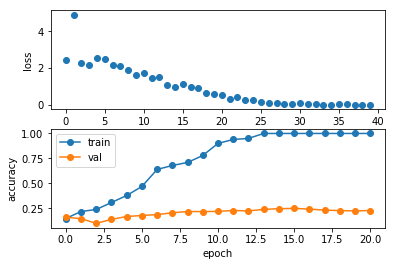

In [15]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train the net
By training the three-layer convolutional network for one epoch, you should achieve greater than 40% accuracy on the training set:

In [18]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001)

solver = Solver(model, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

(Iteration 1 / 980) loss: 2.306806
(Epoch 0 / 1) train acc: 0.122000; val_acc: 0.133000
(Iteration 21 / 980) loss: 2.265088
(Iteration 41 / 980) loss: 2.143845
(Iteration 61 / 980) loss: 2.159170
(Iteration 81 / 980) loss: 2.140021
(Iteration 101 / 980) loss: 2.180964
(Iteration 121 / 980) loss: 1.864730
(Iteration 141 / 980) loss: 1.733170
(Iteration 161 / 980) loss: 2.012108
(Iteration 181 / 980) loss: 1.785111
(Iteration 201 / 980) loss: 1.894504
(Iteration 221 / 980) loss: 1.754493
(Iteration 241 / 980) loss: 2.149640
(Iteration 261 / 980) loss: 2.223957
(Iteration 281 / 980) loss: 1.790465
(Iteration 301 / 980) loss: 1.708594
(Iteration 321 / 980) loss: 1.734906
(Iteration 341 / 980) loss: 1.780485
(Iteration 361 / 980) loss: 1.938594
(Iteration 381 / 980) loss: 1.722890
(Iteration 401 / 980) loss: 1.804486
(Iteration 421 / 980) loss: 1.797731
(Iteration 441 / 980) loss: 1.635691
(Iteration 461 / 980) loss: 1.813387
(Iteration 481 / 980) loss: 1.691378
(Iteration 501 / 980) loss: 

## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following:

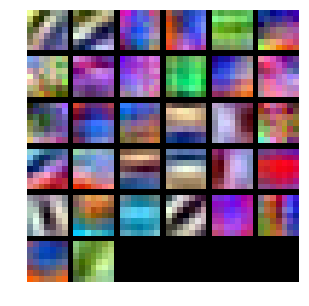

In [19]:
from vis_utils import visualize_grid

grid = visualize_grid(model.params['theta1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

# Experiment!
Experiment and try to get the best performance that you can on CIFAR-10 using a ConvNet. Here are some ideas to get you started:

### Things you should try:
- Filter size: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- Number of filters: Above we used 32 filters. Do more or fewer do better?
- Network architecture: The network above has two layers of trainable parameters. Can you do better with a deeper network? You can implement alternative architectures in the file `convnet.py`. Some good architectures to try include:
    - [conv-relu-pool]xN - conv - relu - [affine]xM - [softmax or SVM]
    - [conv-relu-pool]XN - [affine]XM - [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN - [affine]xM - [softmax or SVM]

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the course-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU
- Model ensembles
- Data augmentation

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at least 65% accuracy on the validation set. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training, validation, and test set accuracies for your final trained network. In this notebook you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.

Have fun and happy training!

In [ ]:
class SmallAlexConvNet(object):
  
    def __init__(self, input_dim=(3, 32, 32), num_filters=[32,32,64], filter_size=[5,3,3],
               hidden_dim=[128,64], num_classes=10, weight_scale=1e-3, reg=0.0,
               dtype=np.float32, stride = 1, use_leaky_relu = False):
        self.params = {}
        self.reg = reg
        self.dtype = dtype
        self.use_leaky_relu = use_leaky_relu

        ############################################################################
        # TODO: Initialize weights and biases for the three-layer convolutional    #
        # network. Weights should be initialized from a Gaussian with standard     #
        # deviation equal to weight_scale; biases should be initialized to zero.   #
        # All weights and biases should be stored in the dictionary self.params.   #
        # Store weights and biases for the convolutional layer using the keys      #
        # 'theta1' and 'theta1_0'; use keys 'theta2' and 'theta2_0' for the        #
        # weights and biases of the hidden affine layer, and keys 'theta3' and     #
        # 'theta3_0' for the weights and biases of the output affine layer.        #
        ############################################################################
        # about 12 lines of code
        check = False
        self.params['theta1'] = np.random.normal(scale = weight_scale, 
                   size = (num_filters[0],input_dim[0],filter_size[0],filter_size[0])) 
        if check:
            assert (num_filters[0],input_dim[0],filter_size[0],filter_size[0]) == (12,3,5,5)
        self.params['theta1_0'] = np.zeros(num_filters[0])

        H = input_dim[1]
        W = input_dim[2]
        HH = filter_size[0]
        WW = filter_size[0]
        pad = 0
        H_out = 1 + (H + 2 * pad - HH) / stride
        W_out = 1 + (W + 2 * pad - WW) / stride

        self.params['theta2'] = np.random.normal(scale = weight_scale,
                   size = (num_filters[1],num_filters[0],filter_size[1],filter_size[1]))
        self.params['theta2_0'] = np.zeros(num_filters[1])


        H = H_out/2
        W = W_out/2
        HH = filter_size[1]
        WW = filter_size[1]
        pad = 0
        H = 1 + (H + 2 * pad - HH) / stride
        W = 1 + (W + 2 * pad - WW) / stride
        self.params['theta3'] = np.random.normal(scale = weight_scale,
                   size = (num_filters[2],num_filters[1],filter_size[2],filter_size[2]))
        self.params['theta3_0'] = np.zeros(num_filters[2])

        HH = filter_size[2]
        WW = filter_size[2]
        pad = 0
        H = 1 + (H + 2 * pad - HH) / stride
        W = 1 + (W + 2 * pad - WW) / stride


        self.params['theta4'] = np.random.normal(scale = weight_scale,
                   size = (num_filters[2]*H*W,hidden_dim[0])) 
        self.params['theta4_0'] = np.zeros(hidden_dim[0])

        self.params['theta5'] = np.random.normal(scale = weight_scale,
                   size = (hidden_dim[0],hidden_dim[1])) 
        self.params['theta5_0'] = np.zeros(hidden_dim[1])

        self.params['theta6'] = np.random.normal(scale = weight_scale,
                   size = (hidden_dim[1],num_classes)) 
        self.params['theta6_0'] = np.zeros(num_classes)

        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        for k, v in self.params.iteritems():
          self.params[k] = v.astype(dtype)

 
    def loss(self, X, y=None):
        """
        Evaluate loss and gradient for the three-layer convolutional network.

        Input / output: Same API as TwoLayerNet in fc_net.py.
        """
        theta1, theta1_0 = self.params['theta1'], self.params['theta1_0']
        theta2, theta2_0 = self.params['theta2'], self.params['theta2_0']
        theta3, theta3_0 = self.params['theta3'], self.params['theta3_0']
        theta4, theta4_0 = self.params['theta4'], self.params['theta4_0']
        theta5, theta5_0 = self.params['theta5'], self.params['theta5_0']
        theta6, theta6_0 = self.params['theta6'], self.params['theta6_0']

        # pass conv_param to the forward pass for the convolutional layer
        filter_size = theta1.shape[2]
        conv_param = {'stride': 1, 'pad': 0}

        # pass pool_param to the forward pass for the max-pooling layer
        pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the three-layer convolutional net,  #
        # computing the class scores for X and storing them in the scores          #
        # variable.                                                                #
        ############################################################################
        # about 3 lines of code (use the helper functions in layer_utils.py)
        #conv - relu - 2x2 max pool - affine - relu - affine - softmax
        scores = X

        cache_ = {}
        scores, cache = conv_relu_pool_forward(scores, theta1, theta1_0, conv_param, pool_param)
        cache_['c1'] = cache
        scores, cache = conv_relu_forward(scores, theta2, theta2_0, conv_param)
        cache_['c2'] = cache
        scores, cache = conv_relu_forward(scores, theta3, theta3_0, conv_param)
        cache_['c3'] = cache
        scores, cache = affine_relu_forward(scores, theta4, theta4_0)
        cache_['c4'] = cache
        scores, cache = affine_relu_forward(scores, theta5, theta5_0)
        cache_['c5'] = cache
        scores, cache = affine_forward(scores, theta6, theta6_0)
        cache_['c6'] = cache

        pass
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        if y is None:
          return scores

        loss, grads = 0, {}
        ############################################################################
        # TODO: Implement the backward pass for the three-layer convolutional net, #
        # storing the loss and gradients in the loss and grads variables. Compute  #
        # data loss using softmax, and make sure that grads[k] holds the gradients #
        # for self.params[k]. Don't forget to add L2 regularization!               #
        ############################################################################
        # about 12 lines of code
        loss, dout = softmax_loss(scores, y)

        cache = cache_['c6']
        dout, grads['theta6'], grads['theta6_0'] = affine_backward(dout, cache)
        loss += self.reg * np.sum(theta6**2)
        grads['theta6'] += theta6 * self.reg

        cache = cache_['c5']
        dout, grads['theta5'], grads['theta5_0'] = affine_relu_backward(dout, cache)
        loss += self.reg * np.sum(theta5**2)
        grads['theta5'] += theta5 * self.reg


        cache = cache_['c4']
        dout, grads['theta4'], grads['theta4_0'] = affine_relu_backward(dout, cache)
        loss += self.reg * np.sum(theta4**2)
        grads['theta4'] += theta4 * self.reg

        cache = cache_['c3']
        dout, grads['theta3'], grads['theta3_0'] = conv_relu_backward(dout, cache)
        loss += self.reg * np.sum(theta3**2)
        grads['theta3'] += theta3 * self.reg

        cache = cache_['c2']
        dout, grads['theta2'], grads['theta2_0'] = conv_relu_backward(dout, cache)
        loss += self.reg * np.sum(theta2**2)
        grads['theta2'] += theta2 * self.reg

        cache = cache_['c1']
        dout, grads['theta1'], grads['theta1_0'] = conv_relu_pool_backward(dout, cache)
        loss += self.reg * np.sum(theta1**2)
        grads['theta1'] += theta1 * self.reg

        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads


model = SmallAlexConvNet(weight_scale=0.001, reg=0.00001)

solver = Solver(model, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 4e-3,
                },
                verbose=True, print_every=20)
solver.train()

(Iteration 1 / 980) loss: 2.302594
(Epoch 0 / 1) train acc: 0.108000; val_acc: 0.112000
(Iteration 21 / 980) loss: 2.293969
(Iteration 41 / 980) loss: 2.321305
(Iteration 61 / 980) loss: 2.213864
(Iteration 81 / 980) loss: 2.123841
(Iteration 101 / 980) loss: 2.146481
(Iteration 121 / 980) loss: 1.975101
(Iteration 141 / 980) loss: 2.186599
(Iteration 161 / 980) loss: 2.156163
(Iteration 181 / 980) loss: 2.119841
(Iteration 201 / 980) loss: 1.840981
(Iteration 221 / 980) loss: 1.993350
(Iteration 241 / 980) loss: 1.996445
(Iteration 261 / 980) loss: 1.843483
(Iteration 281 / 980) loss: 1.857305
(Iteration 301 / 980) loss: 1.991779
(Iteration 321 / 980) loss: 1.903233
(Iteration 341 / 980) loss: 1.765655
(Iteration 361 / 980) loss: 2.194091
(Iteration 381 / 980) loss: 1.737678
(Iteration 401 / 980) loss: 1.851186
(Iteration 421 / 980) loss: 1.874517


# Extra Credit Description
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.